In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [2]:
preprocessed_data = pd.read_csv(r'/Users/issackondreddy/Desktop/Projects/Fraud Detection System/DS/data/processed_creditcard.csv')
preprocessed_data.head()

,Scaled_Time,Scaled_Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.996583,0.244964,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-1.996583,-0.342475,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-1.996562,0.140534,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
3,-1.996541,-0.073403,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
4,-1.996541,-0.338556,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,...,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0


In [3]:
# Separate features and target
X = preprocessed_data.drop('Class', axis=1)
y = preprocessed_data['Class']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
lgb_model = lgb.LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 85646, number of negative: 156412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 242058, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353824 -> initscore=-0.602271
[LightGBM] [Info] Start training from score -0.602271


LGBMClassifier(max_depth=6, n_estimators=200)

In [6]:
# Get GBDT predictions (probabilities)
train_gbdt_predictions = lgb_model.predict_proba(X_train)[:, 1].reshape(-1, 1)
test_gbdt_predictions = lgb_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

In [7]:
X_train_hybrid = np.hstack([X_train, train_gbdt_predictions])
X_test_hybrid = np.hstack([X_test, test_gbdt_predictions])

In [8]:
# Check the new shapes of training and test data
print(f"Shape of new training data: {X_train_hybrid.shape}")
print(f"Shape of new test data: {X_test_hybrid.shape}")

Shape of new training data: (242058, 31)
Shape of new test data: (80686, 31)


In [9]:
model = Sequential()
model.add(Dense(128, input_dim=X_train_hybrid.shape[1], activation='relu'))  # Input size matches the hybrid feature set
model.add(Dropout(0.3))  # Regularization
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

/Users/issackondreddy/Desktop/Projects/Fraud Detection System/FDS/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(X_train_hybrid, y_train, epochs=10, batch_size=32, validation_data=(X_test_hybrid, y_test))


Epoch 1/10
7565/7565 ━━━━━━━━━━━━━━━━━━━━ 3s 396us/step - accuracy: 0.9929 - loss: 0.0224 - val_accuracy: 0.9996 - val_loss: 0.0047
Epoch 2/10
7565/7565 ━━━━━━━━━━━━━━━━━━━━ 3s 398us/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9996 - val_loss: 0.0040
Epoch 3/10
7565/7565 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step - accuracy: 0.9999 - loss: 6.1067e-04 - val_accuracy: 0.9996 - val_loss: 0.0037
Epoch 4/10
7565/7565 ━━━━━━━━━━━━━━━━━━━━ 3s 385us/step - accuracy: 0.9999 - loss: 5.6807e-04 - val_accuracy: 0.9996 - val_loss: 0.0033
Epoch 5/10
7565/7565 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step - accuracy: 0.9999 - loss: 3.5642e-04 - val_accuracy: 0.9998 - val_loss: 0.0021
Epoch 6/10
7565/7565 ━━━━━━━━━━━━━━━━━━━━ 3s 419us/step - accuracy: 0.9999 - loss: 4.9380e-04 - val_accuracy: 0.9996 - val_loss: 0.0060
Epoch 7/10
7565/7565 ━━━━━━━━━━━━━━━━━━━━ 3s 402us/step - accuracy: 0.9999 - loss: 0.0013 - val_accuracy: 0.9997 - val_loss: 0.0045
Epoch 8/10
7565/7565 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step - ac

In [12]:
# Predict the probabilities and labels
y_pred_proba = model.predict(X_test_hybrid).ravel()  # Get predicted probabilities
y_pred = (y_pred_proba >= 0.5).astype(int)  # Convert to binary (0 or 1)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

2522/2522 ━━━━━━━━━━━━━━━━━━━━ 1s 249us/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52206
           1       1.00      1.00      1.00     28480

    accuracy                           1.00     80686
   macro avg       1.00      1.00      1.00     80686
weighted avg       1.00      1.00      1.00     80686

Confusion Matrix:
[[52179    27]
 [    1 28479]]


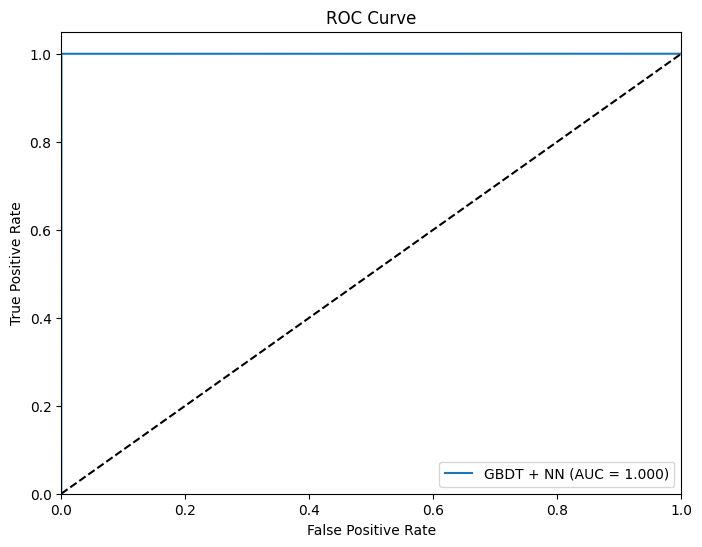

AUC-ROC Score: 1.000


In [13]:
# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'GBDT + NN (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random model baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC-ROC score
print(f"AUC-ROC Score: {roc_auc:.3f}")


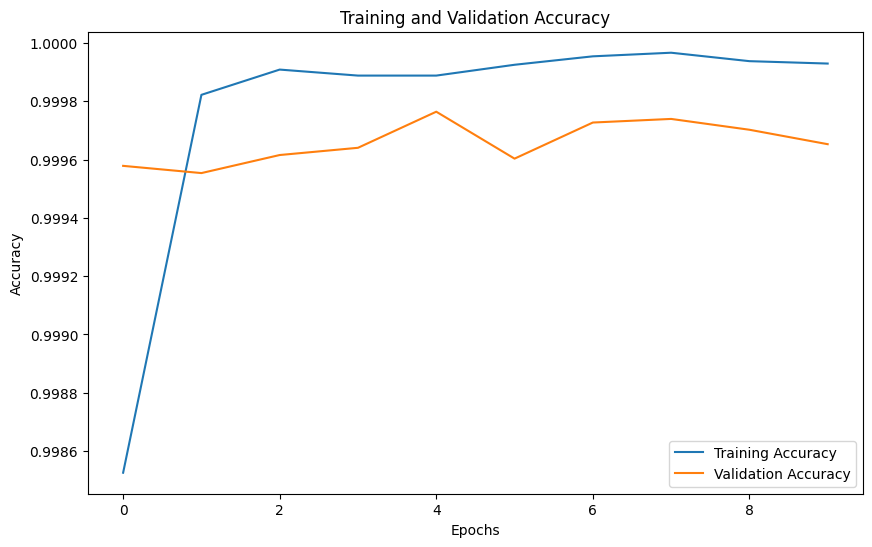

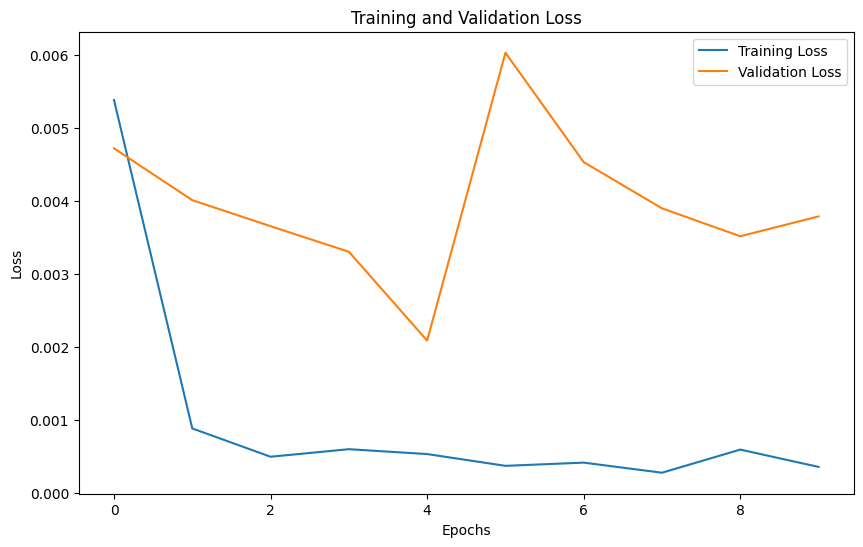

In [14]:
# Accuracy curve
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss curve
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


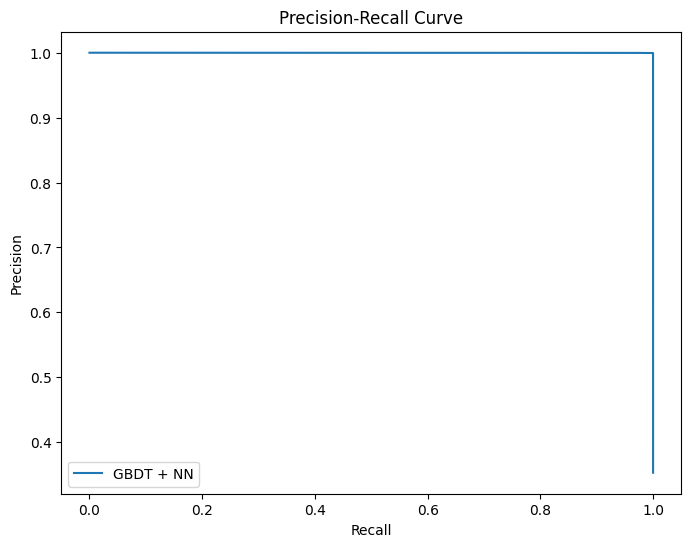

In [15]:
from sklearn.metrics import precision_recall_curve

# Generate precision-recall data
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Plot the precision-recall curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='GBDT + NN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [16]:
# Classification report
report = classification_report(y_test, y_pred, output_dict=True)

print(f"Accuracy: {report['accuracy']:.3f}")
print(f"Precision: {report['1']['precision']:.3f}")
print(f"Recall: {report['1']['recall']:.3f}")
print(f"F1-Score: {report['1']['f1-score']:.3f}")


Accuracy: 1.000
Precision: 0.999
Recall: 1.000
F1-Score: 1.000
